<center><span style="color:blue">IFMG EXPERTS FINDER - KNOWLEDGE REPRESENTATION USING WORD2VEC AND INFORMATION RETRIEVAL USING TF-IDF</span></center>





## AS PRÓXIMAS FUNÇÕES SÃO GERAIS DE TODO O NOTEBOOK

#### Autores: Amarildo Magalhães e Danielle Rioga - novembro/2017

###### Procedimentos adotados:


1. O word2vec foi treinando usando corpous de 200mil, 400mil e 1 milhão de  currículos. Não houve uma diferença significante entre os 3 testes, mas houve uma diferença significativa do corpus de 1700 currículos (apenas do IFMG).
2. Foi usada a lista de stopwords do nltk em português, no entanto, como essa lista contém apenas poucos artigos, preposições e conjunções, foi criada uma lista complementar, contendo mais 99 preposições e conjunções.
3. Todas as palavras do texto foram passadas para minúsculo e todos os acentos foram removidos. 
4. A função principal do word2vec nesse trabalho seria expandir as palavras-chave de cada projeto de pesquisa. Para essa expansão, foram usadas as duas palavras mais similares a cada keyword encontradas pelo word2vec. 
5. No primeiro treino do word2vec, não foram removidos os verbos e a lista complementar de conjunções criadas. 
6. Foi utilizado um processamento para que as palavras no plural fossem convertidas para o singular, ampliando assim o cálculo do TF-IDF.
7. Ao total foram considerados 2336 currículos dos servidores do IFMG. esses currículos foram extraídos do lattes com base no CPF do servidor.
9. Foi gerada uma lista de 260524 verbos, considerando sua forma infinitiva e todas suas conjugações possíveis com base em um crawler desenvolvido pelos autores 
10. Os seguintes projetos de pesquisa do IFMG foram submetidos ao sistema para verificar os profissionais mais aptos a avaliá-los:

    - __PROJETO 1__: Avaliação das propriedades físico-hídrico do solo nas áreas de recargas de nascentes sob diferentes usos do solo
    - __PROJETO 2__: Desenvolvimento de tecnologia para tratamento de rejeito de minério de ferro com uso de separação por floculação e decantação magnética
    - __PROJETO 3__: SUPLEMENTAÇÃO DE MINERAIS ORG NICOS EM DIETAS PARA FRANGOS CAIPIRA
    - __PROJETO 4__: AVALIAÇÃO DA ATIVIDADE BIOCIDA DE EXTRATOS BRUTOS DE PLANTAS MEDICINAIS NATIVAS DO ALTO PARAOPEBA FRENTE À BIOTERIORAÇÃO DA PEDRA SABÃO



In [5]:
#comando para autocomplete
%config IPCompleter.greedy=True

In [6]:
#funcao para converter palavra do plural para singular

def pluraltosingular(palavra):
    if palavra[-1] != 's':
        return palavra
    #albuns batons marrons
    elif palavra[-2] == 'n':
        return palavra[0:-2]+'m'
    #flores gizes vezes tenis
    elif not any((c in 'aeou') for c in palavra[:1]) and palavra[-2] == 'e' and any((c in 'nrsz') for c in palavra[-3]):
        return palavra[:-2]
    # aneis anzois jornais
    elif palavra[-2:] == "is" and any((c in 'aeiou') for c in palavra[-3]): 
        return palavra[:-2]+'l'    
    # frances portugues
    elif palavra[-2:] == "es" and any((c in 'clu') for c in palavra[-3]): 
        return palavra
    # caes paes
    elif palavra[-3:] == "aes": 
        return palavra[:-2]+'o'
    # leoes
    elif palavra[-3:] == "oes": 
        return palavra[:-3]+'ao'
    elif not any((c in 'ius') for c in palavra[-2]) and palavra[-3] != 'n':
        return palavra[:-1]
    return palavra


In [7]:
def removeCharAcento(palavra): 
    
    #limpar o texto - retira acentos e caracteres especiais do texto
    import unicodedata
    import re

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 ]', '', palavraSemAcento.lower())

In [8]:
#remoção de stopwords - disjunções, preposições, artigos, etc...
def removeStopWords(texto, string=False, verbos=True):
    
    text = []
    
    for t in texto:
        text.append(t.lower())
    
    #vamos criar uma lista de conjunções, preposições e advérbios extraído de https://en.wiktionary.org/wiki/Category:Portuguese_conjunctions

    conj_prep = "que agora ainda apesar assim como caso se conforme conquanto contanto de desde e e/ou em quanto embora enquanto entao entretanto logo mais mas mesmo muito nem onde quer ora ou para pois por isso isto porem porquanto porque quando quanto se somente segundo senao sendo si so tao logo uma vez a o e i u alem ante longo aos apesar apos apud ate atras atraves acerca com como contra dentre dentro depois desde devido diante durante elevado em embaixo enquanto entre exceto ha inves mais menos para perante por quanto quando quao segundo sem sobre sob versus"

    from nltk.corpus import stopwords

    stops          = set(stopwords.words("portuguese"))
    stopsSemAcento = []

    for ele in stops:
        stopsSemAcento.append(removeCharAcento(ele))
    
    stopsSemAcento += conj_prep.split()
    
    #se eh para remover os verbos tambem
    if verbos==True:
        import json
        filename = "../datasets/ifmg/verbos.json" #lista de verbos no infinitvo, gerundio e todas as conjugações possíveis

        with open(filename) as data_file:    
            stopsSemAcento += json.load(data_file)
    
    lista_sem_stopwords = [w for w in text if w not in stopsSemAcento]
    
    if string==False:
        return lista_sem_stopwords
    else:
        return ' '.join(map(str,lista_sem_stopwords))
        

In [9]:
#função para pegar conjugacao do verbo usando o site http://www.conjuga-me.net
def get_conjugacao(verbo):
    
    vet_conjuga = []
    
    query4url = urllib.request.pathname2url(verbo)

    conjuga_url = 'http://www.conjuga-me.net/verbo-'+query4url
    
    #print("Pesquisando conjugações por meio da URL: ",conjuga_url)

    rawpages_conjuga = urllib.request.urlopen(conjuga_url).read().decode('ISO-8859-1')

    td_conjuga = re.findall(r'(?i)<td([^>]+)>(.+?)</td>',rawpages_conjuga,flags=re.S) #a flag re.S pega quebra de linha

    for td in td_conjuga:
        classe = td[0][8:14]
        if classe == 'output':
            inicio = td[1][0:5]
            if inicio == '<span':
                conjugacao = td[1][20:-7]
                pos_span = int(conjugacao.find('<'))
                if pos_span > 0:
                    conjugacao = conjugacao[0:pos_span] 
                #print(conjugacao)
            else:
                conjugacao = td[1]
            vet_conjuga.append(conjugacao)
        else:
            inicio    = td[0][20:29].strip()
            if inicio == 'gerund"' or inicio == 'partpass"':
                pos_span = int(td[1].find('> '))+2
                valor    = td[1][pos_span:].strip()
                vet_conjuga.append(valor)
            
    
    return vet_conjuga


In [10]:
#vamos montar um dicionário com verbos 
import urllib
import re
import os

filename = "../datasets/ifmg/verbos.json"

#os verbos serão extraídos daqui https://www.conjugacao.com.br/verbos-populares/22/

#antes de qualquer coisa, vamos verificar se o arquivo já existe

filesize = os.stat(filename).st_size 

if filesize==1: #se o arquivo ainda não tem os verbos

    url              = 'https://www.conjugacao.com.br/verbos-populares/'
    qtepag           = 50 #qte de subpáginas
    i                = 1
    rawpages         = ''
    verbos_vet       = [] #vetor para receber os verbos
    palavras_remover = ['Próxima','Lista de verbos','Verbos regulares','Verbos irregulares','Anterior'] #palavras a serem desprezadas

    while i <= qtepag:
        newurl = url+str(i)+'/'
        rawpages += urllib.request.urlopen(newurl).read().decode('ISO-8859-1')
        i += 1

    #vamos extrair apenas os links    
    urls = re.findall(r'(?i)<a([^>]+)>(.+?)</a>',rawpages)
    for url in urls:
        inicio = url[0][8:13]
        if inicio == 'verbo' and url[1].isdigit()==False:
            verbos_vet.append(url[1])

    #vamos remover a lista de palavras que não são verbos identificadas no texto
    verbosFinal = [w for w in verbos_vet if w not in palavras_remover]

    print("Tamanho do dicionário de verbos na forma simples: ",len(verbosFinal))

    verbos_conjugados = [] #lista final de verbos verbos_conjugados

    for verbo in verbosFinal:
        #print("Vamos ver as conjugações do verbo ",verbo)
        verbos_conjugados.append(verbo) #adiciona o verbo origem ao vetor final
        lista_conjugacoes = get_conjugacao(verbo) #pega lista de conjugacoes do verbo origem
        for verbo_conjugado in lista_conjugacoes: #enquanto houver conjugacoes desse verbo
            verbos_conjugados.append(verbo_conjugado) #adiciona ao vetor final

    print("Tamanho do dicionário incluindo conjugações: ",len(verbos_conjugados))

    if len(verbos_conjugados)>0:

        #vamos salvar um arquivo json com esses verbos
        import json

        #verbos_json = json.dump(verbos_conjugados)

        with open(filename, 'w') as outfile:
            json.dump(verbos_conjugados, outfile)


    print(len(verbos_conjugados))

__O corpus do currículo é montado considerando:__
 - Projetos de pesquisa e desenvolvimento
 - Experiência profissional
 - Resumo do currículo
 - Publicações



In [11]:
#função recupera dados do CV em XML

def extrai_xml(cv_id):
    
    import xml.etree.ElementTree as eT
    
    stringCV = ''
    
    root = eT.parse(cv_id).getroot()

    for dados in root.findall('DADOS-GERAIS'):
        nomeCV = dados.get('NOME-COMPLETO') 
        for atu in dados.findall('ATUACOES-PROFISSIONAIS'):
            for pesq in atu.findall('ATUACAO-PROFISSIONAL'):
                #pesquisa todos as participações em projeto de pesquisa nessa atuação profissional
                for proj in pesq.findall('ATIVIDADES-DE-PARTICIPACAO-EM-PROJETO'):
                    for part_projeto in proj.findall('PARTICIPACAO-EM-PROJETO'):
                        for proj_pesquisa in part_projeto.findall('PROJETO-DE-PESQUISA'):
                            descricao_projeto = proj_pesquisa.get('DESCRICAO-DO-PROJETO')
                            #adiciona os projetos de pesquisa ao corpus
                            if descricao_projeto is not None:
                                stringCV += descricao_projeto+' ' 

                #pesquisa todas as linhas de pesquisa participadas
                for ati_pesq in pesq.findall('ATIVIDADES-DE-PESQUISA-E-DESENVOLVIMENTO'):
                    for pesq_desenv in ati_pesq.findall('PESQUISA-E-DESENVOLVIMENTO'):
                        for linha_pesquisa in pesq_desenv.findall('LINHA-DE-PESQUISA'):
                            obj_linha_pesquisa = linha_pesquisa.get('OBJETIVOS-LINHA-DE-PESQUISA')
                            #adiciona as linhas de pesquisa ao corpus
                            if obj_linha_pesquisa is not None:
                                stringCV += obj_linha_pesquisa+' ' 

    for dados in root.iter('RESUMO-CV'):
        resumo = dados.get('TEXTO-RESUMO-CV-RH')        
        #adiciona o resumo do CV ao corpus
        if resumo is not None:
            stringCV += resumo+' ' 
        
    return [nomeCV,stringCV]

In [85]:
#vamos gerar o vetor de palavras

def create_vetor_corpus(corpus,removeVerbos=True):

    vetCorpus = []

    for ele in corpus:
        lista_palavras_sem_acento    = removeCharAcento(str(ele)).split() #removendo caracteres especiais e acentos
        lista_palavras_sem_stopwords = removeStopWords(lista_palavras_sem_acento,string=False,verbos=removeVerbos) #removeStopWords(texto, string=False, verbos=True)
        vetCorpus.append(lista_palavras_sem_stopwords)

    #print(len(vetCorpus))
    
    return vetCorpus

In [13]:
def treino_modelo(corpus,model_name):

    from gensim.models import Word2Vec

    #vamos treinar o modelo
    
    model_save = '../datasets/ifmg/'+model_name+'.bin'

    model = Word2Vec(corpus, min_count=2, size=300, window=4)

    model.wv.save_word2vec_format(model_save, binary=True)
    
    return model

In [14]:
#trabalhando com o modelo gerado

#essa funcao retorna as palavras mais próximas de uma determinada palavra

def similar_word(modelo,word):

    #print(model[word])

    print('Palavras mais similiares a palavra: ',word)
    for palavra_similar in modelo.most_similar(word,topn=5): #topn=len(model[word])) - tamanho total do vetor da palavra
        print(palavra_similar)
    
    print()

In [145]:
#vamos treinar o modelo word2vec e fazer o teste com 4 palavras

def executa_teste_palavras(model):

    #print("Quantidade de sentenças do corpus: ",len(corpus))

    print("Modelo gerado: ",model)

    word1 = 'marketing' 
    #word2 = 'futebol'
    word3 = 'software'
    word4 = 'agricultura'

    similar_word(model,word1)
    #similar_word(model,word2)
    similar_word(model,word3)
    similar_word(model,word4)


In [16]:
#funcao para retornar x palavras mais próximas

def retorna_palavras_similares(model,texto,qte_similares,lista=False):
    
    vetor_expandido = []
    #print(texto.split())
    vetor_palavras  = removeStopWords(texto.split())
    #print(vetor_palavras)
    for w in vetor_palavras:
        j = w.lower()
        #print(j)
        vetor_expandido.append(j)
        try:
            similares = model.most_similar(j,topn=qte_similares) #vetor palavras similares
            for s in similares:
                vetor_expandido.append(s[0].lower())
        except KeyError:
            d = 1
        
        #vamos adicionar a mesma palavra no singular
        #singular = pluraltosingular(j)
        #vetor_expandido.append(singular)
    
    vetor_expandido = list(set(vetor_expandido))
    if lista==True:
        return vetor_expandido
    else:
        return ' '.join(vetor_expandido)    

### Treino 1: corpus apenas com a base de currículos do IFMG (1700 currículos lattes)

A imagem abaixo apresenta o resultado para as palavras MARKETING, SOFTWARE e AGRICULTURA:


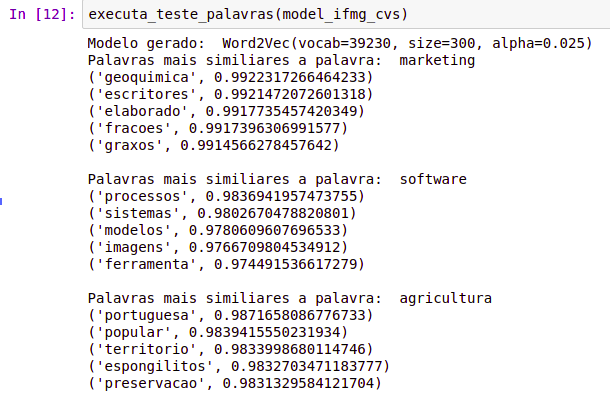

In [152]:
#o word2vec foi treinando considerando os 1700 currículos dos servidores do IFMG
from IPython.display import display, Image

datapath = '../datasets/ifmg/images/'

print("A imagem abaixo apresenta o resultado para as palavras MARKETING, SOFTWARE e AGRICULTURA:")

display(Image(os.path.join(datapath,'teste-corpus-ifmg.png'), width=700))

### Treino 2, 3 e 4 - Vamos gerar um outro corpus, agora com 400mil currículos lattes

In [ ]:
#extrai todos os arquivos xml dentro dos arquivos zip

lista_extrair = ['1','2'] #each folder has 200k Lattes Resumes

for pasta in lista_extrair:
    path_zips = "/media/magalhaes/MAGALHAES/Ufmg/Doutorado/Lattes/zip/"+pasta+'/'
    #path_zips = "/home/magalhaes/Downloads/lattes/1/"
    extract_xml(path_zips,pasta)

In [153]:
#vamos ler o arquivo xml com os curriculos 
import json
import os.path

filename  = '../datasets/ifmg/corpus.json'
vetCorpus = []

if os.path.exists(filename): #se arquivo json com corpus já existe existe
    
    with open(filename) as data_file:    
        vetCorpus = json.load(data_file).split('|')

if(len(vetCorpus)==0):
    
    path_xml = "../datasets/ifmg/cvs/xml/"
    import xml.etree.ElementTree as eT
    from os import listdir
    from os.path import isfile, join

    lista_extrair = ['1','2'] #each folder has 200k Lattes Resumes

    for pasta in lista_extrair:
        path_xml_completo = path_xml+pasta+'/'
        xmlFiles = [f for f in listdir(path_xml_completo) if isfile(join(path_xml_completo, f))]

        for xml in xmlFiles:
            stringCV = extrai_xml(path_xml_completo+xml)[1]
            vetCorpus.append(stringCV)


In [ ]:
path_xml = "/home/magalhaes/NetBeansProjects/machinelearning/ufmg/MMD/datasets/ifmg/cvs/xml/"

import os
import zipfile
 
def unzip(file_name,pasta): 
    destino = path_xml+pasta+'/'
    file_size = os.path.getsize(file_name)
    if(file_size>0):
        with zipfile.ZipFile(file_name, 'r') as zf:
            xmlName = zf.namelist()[0]
            zf.extract(xmlName, destino)

            # List all *.zip files and extract them.
def extract_xml(dir,pasta):
    for arquivo in os.listdir(dir): #arquivo do diretorio
        extzip = os.path.splitext(arquivo)[1] #extensao do arquivo
        if(extzip=='.zip'):
            unzip(dir+arquivo,pasta)

In [154]:
#vamos criar o vetor de palavras com base nas informações do CV

vet_sentencas_treino = create_vetor_corpus(vetCorpus,removeVerbos=False)

***

In [ ]:
#as proximas linhas até o treino do vetor não precisam ser executadas caso não deseje remover os verbos do corpus

In [18]:
#qte de curriculos do corpus
print("Qte de currículos do corpus: ",len(vetCorpus))

#vamos salvar um arquivo json com o texto dos currículos
filename = '../datasets/ifmg/corpus.json'

import json
import zipfile as zf

with open(filename, 'w') as outfile:
    json.dump('|'.join(vetCorpus), outfile)

Qte de currículos do corpus:  400189


In [73]:
#vamos remover os verbos do corpus e stopwords para testar o treindo do word2vec sem os verbos
import time
start_time = time.time()

import json

stopsSemAcento  = []
vetCorpus_limpo = []

conj_prep  = "que agora ainda apesar assim como caso se conforme conquanto contanto de desde e e/ou em quanto embora enquanto entao entretanto logo mais mas mesmo muito nem onde quer ora ou para pois por isso isto porem porquanto porque quando quanto se somente segundo senao sendo si so tao logo uma vez a o e i u alem ante longo aos apesar apos apud ate atras atraves acerca com como contra dentre dentro depois desde devido diante durante elevado em embaixo enquanto entre exceto ha inves mais menos para perante por quanto quando quao segundo sem sobre sob versus"
stop_words = ['este', 'já', 'seus', 'seu', 'tenham', 'por', 'pelo', 'tinha', 'tivéssemos', 'teríamos', 'será', 'nas', 'teriam', 'suas', 'estivera', 'que', 'eles', 'nossa', 'vocês', 'às', 'isto', 'estas', 'estive', 'houveriam', 'quem', 'teus', 'lhes', 'esta', 'minhas', 'foram', 'na', 'sejamos', 'nossas', 'houve', 'fosse', 'estávamos', 'pelas', 'estes', 'fomos', 'houvessem', 'estava', 'ela', 'fôssemos', 'terá', 'houver', 'eram', 'nem', 'meus', 'sou', 'haja', 'as', 'ou', 'éramos', 'vos', 'houvermos', 'essa', 'forem', 'seriam', 'da', 'tiver', 'seríamos', 'foi', 'das', 'houverei', 'tenhamos', 'seria', 'te', 'teu', 'estou', 'tiveram', 'o', 'isso', 'só', 'sua', 'aqueles', 'esteve', 'houveremos', 'tenha', 'tivessem', 'tenho', 'de', 'estivéssemos', 'houverá', 'houveria', 'esteja', 'houvesse', 'tive', 'no', 'houverem', 'lhe', 'estão', 'estivéramos', 'sem', 'dos', 'hão', 'ao', 'hajamos', 'para', 'dela', 'terei', 'teve', 'hajam', 'tivéramos', 'dele', 'nos', 'delas', 'a', 'estivesse', 'temos', 'aquilo', 'do', 'qual', 'estiveram', 'mais', 'aquelas', 'tém', 'eu', 'tivera', 'deles', 'estejam', 'hei', 'havemos', 'tem', 'ele', 'depois', 'numa', 'nosso', 'estivessem', 'fossem', 'se', 'e', 'estamos', 'entre', 'um', 'tivesse', 'seremos', 'como', 'também', 'nossos', 'houverão', 'à', 'tivemos', 'minha', 'nós', 'teremos', 'tivermos', 'pelos', 'essas', 'estiverem', 'serão', 'você', 'houveríamos', 'esse', 'houvemos', 'até', 'serei', 'são', 'tua', 'com', 'esses', 'há', 'tuas', 'somos', 'houveram', 'em', 'me', 'está', 'mesmo', 'tu', 'houvera', 'houvéramos', 'num', 'pela', 'terão', 'tínhamos', 'formos', 'fôramos', 'houvéssemos', 'seja', 'for', 'estiver', 'tiverem', 'mas', 'quando', 'aos', 'aquele', 'sejam', 'estivermos', 'era', 'estavam', 'não', 'meu', 'uma', 'estivemos', 'aquela', 'fui', 'os', 'elas', 'fora', 'teria', 'muito', 'estejamos', 'tinham']

stopsSemAcento += conj_prep.split()
stopsSemAcento += stop_words

filename = "../datasets/ifmg/verbos.json" #lista de verbos no infinitvo, gerundio e todas as conjugações possíveis    
with open(filename) as data_file:    
    stopsSemAcento += json.load(data_file)

qtecvs_proc = len(vetCorpus)-350001
start       = 350001
stop        = (qtecvs_proc+start)
while(start<stop):
    lista_palavras_sem_acento    = removeCharAcento(str(vetCorpus[start])).split() #removendo caracteres especiais e acentos
    lista_palavras_sem_stopwords = [w for w in lista_palavras_sem_acento if w not in stopsSemAcento]
    vetCorpus_limpo.append(lista_palavras_sem_stopwords)
    start+=1

elapsed_time = time.time() - start_time

print('\nTempo processamento cvs foi : ',elapsed_time)
print('\nTamanho do corpus limpo : ',len(vetCorpus_limpo))


Tempo processamento cvs foi :  8534.788120985031

Tamanho do corpus limpo :  50188


In [74]:
#vamos salvar um arquivo json com o texto dos currículos
filename = '../datasets/ifmg/corpus_limpo_ate_'+str(start)+'.json'

vetCorpus_limpo_srt = []

for i in vetCorpus_limpo:
    stri = ' '.join(i)
    vetCorpus_limpo_srt.append(stri)

import json

with open(filename, 'w') as outfile:
    json.dump('|'.join(vetCorpus_limpo_srt), outfile)

In [144]:
#vamos juntar os arquivos gerados para criar o corpus e treinar o word2vec

vetCorpus1 = []
vetCorpus2 = []
vetCorpus3 = []
vetCorpus4 = []
vetCorpus5 = []


file1 = '../datasets/ifmg/corpus_limpo_ate_50001.json'
file2 = '../datasets/ifmg/corpus_limpo_ate_100001.json'
file3 = '../datasets/ifmg/corpus_limpo_ate_250001.json'
file4 = '../datasets/ifmg/corpus_limpo_ate_350001.json'
file5 = '../datasets/ifmg/corpus_limpo_ate_400189.json'

with open(file1) as data_file:    
    vetCorpus1 = json.load(data_file).split('|')

with open(file2) as data_file:    
    vetCorpus2 = json.load(data_file).split('|')

with open(file3) as data_file:    
    vetCorpus3 = json.load(data_file).split('|')

with open(file4) as data_file:    
    vetCorpus4 = json.load(data_file).split('|')

with open(file5) as data_file:    
    vetCorpus5 = json.load(data_file).split('|')

vetCorpus_sem_verbos = vetCorpus1+vetCorpus2+vetCorpus3+vetCorpus4+vetCorpus5

vet_sentencas_treino = []

for i in vetCorpus_sem_verbos:
    vet_sentencas_treino.append(i.split())

print('Tamanho do corpus : ',len(vet_sentencas_treino))

#print("Primeira posição do corpus : ",vet_sentencas_treino[0])

Tamanho do corpus :  400188


In [90]:
print("Primeira posicao do vetor: ",vet_sentencas_treino[0])

Primeira posicao do vetor:  ['graduacao', 'direito', 'universidade', 'catolica', 'goias', '1998', 'graduacao', 'agronomia', 'universidade', 'federal', 'vicosa', '1985', 'atualmente', 'uniao', 'advocacia', 'geral', 'uniao', 'enfase', 'elaboracao', 'legislativa', 'diretor', 'departamento', 'elaboracao', 'legislativa', 'assuntos', 'legislativos', 'ministerio', 'justica', '2', 'agosto', '2006', 'dia', '9', 'abril', '2007', 'coordenadorgeral', 'atos', 'normativos', 'departamento', 'elaboracao', 'normativa', 'assuntos', 'legislativos', 'ministerio', 'justica', '14', 'outubro', '2005', '1', 'agosto', '2006', 'diretor', 'departamento', 'elaboracao', 'legislativa', 'assuntos', 'legislativos', 'ministerio', 'justica', '9', 'julho', '2004', '13', 'outubro', '2005', 'tambem', 'assuntos', 'legislativos', 'ministerio', 'justica', 'substituto', 'ano', '2005', 'secao', '2', '7012005', '28022005', 'atualmente', 'presidencia', 'camara', 'deputados', 'assessoramento', 'juridico', 'consultoria', 'legislat

***

In [158]:
#vamos treinar o modelo do word2vec com o corpus extraído a partir das informações do CV Lattes
model_name = 'model400CVs'
model      = treino_modelo(vet_sentencas_treino,model_name)

In [159]:
#recuperando modelo treinado
import gensim
model_name  = 'model400CVs'
model_save  = '../datasets/ifmg/'+model_name+'.bin'
model       = gensim.models.KeyedVectors.load_word2vec_format(model_save, binary=True)


In [160]:
executa_teste_palavras(model)

Modelo gerado:  <gensim.models.keyedvectors.KeyedVectors object at 0x7fe0de958f60>
Palavras mais similiares a palavra:  marketing
('propaganda', 0.6600313782691956)
('branding', 0.6591063737869263)
('varejo', 0.6536749601364136)
('espm', 0.6162213683128357)
('negocios', 0.6153029203414917)

Palavras mais similiares a palavra:  software
('softwares', 0.6451354026794434)
('framework', 0.6156809329986572)
('web', 0.600820779800415)
('aplicativo', 0.5968745946884155)
('matlab', 0.5683216452598572)

Palavras mais similiares a palavra:  agricultura
('pecuaria', 0.6191912889480591)
('cafeicultura', 0.5904030799865723)
('fruticultura', 0.5888192653656006)
('agroindustria', 0.5707234144210815)
('horticultura', 0.5693240761756897)



***

### VAMOS MONTAR O CORPUS DOS CURRÍCULOS E USAR O TF-IDF PARA REPRESENTÁ-LO

In [99]:
#vamos ler o arquivo xml com o curriculo e armazenar as info de cada cv no vetor vetCVS
path_xml = "../datasets/ifmg/xml/servidores/"
from os import listdir
from os.path import isfile, join

xmlFiles = [f for f in listdir(path_xml) if isfile(join(path_xml, f))]
vetCVS   = []
vetPRO   = []

for xml in xmlFiles:
    filename = path_xml+xml
    vet_cv = extrai_xml(filename)
    nomeCV = vet_cv[0]
    descCV = vet_cv[1]
    texto_sem_acento = removeCharAcento(str(descCV)) #removendo caracteres especiais e acentos
    vetCVS.append(texto_sem_acento)
    vetPRO.append(nomeCV)
  
print("Tamanho do vetor de CVS: ",len(vetCVS))

Tamanho do vetor de CVS:  2336


In [100]:
#vamos criar um vetor para associar o nome do pesquisador com o currículo

vetor_nomes = {}
vetor_cvs = {}

n = 0
for d in vetCVS:
    nome_pro = vetPRO[n]
    cv_abr = d[:70]
    vetor_nomes[cv_abr] = nome_pro #acha o nome do servidor com base nos primeiros 50char do cv
    vetor_cvs[nome_pro] = d #acha o cv do servidor com base no seu nome
    n += 1
  
    
print("Qte de currículos no corpus: ",len(vetCVS))

Qte de currículos no corpus:  2336


In [101]:
print(len(vetCVS))

2336


In [102]:
#vamos percorrer o vetCVS e remover stopwords
from nltk.tokenize import word_tokenize
#remove stopwords e gera tokens    
gen_docs = [removeStopWords([w.lower() for w in word_tokenize(text)]) for text in vetCVS] 

In [104]:
#vamos gerar o dicionário
import gensim
dictionary = gensim.corpora.Dictionary(gen_docs)
print(dictionary[5])
print(dictionary.token2id['educacao'])
print("Number of words in dictionary:",len(dictionary))
#for i in range(len(dictionary)):
 #   print(i, dictionary[i])

2013
10
Number of words in dictionary: 27443


In [105]:
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]

print("Qte currículos do IFMG no courpus: ",len(corpus))

#d = 100
#print(corpus[d],gen_docs[d],len(corpus[d]),len(gen_docs[d]))



Qte currículos do IFMG no courpus:  2336


In [106]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    #s += len(i)
    print(i)
    #print()
    #print(vetor_assoc_final[s])
    break
#print(s)

TfidfModel(num_docs=2336, num_nnz=174950)
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [107]:
outputs = "../outputs/"
index = gensim.similarities.Similarity(outputs,tf_idf[corpus],num_features=len(dictionary))
print(index)
#print(type(sims))

Similarity index with 2336 documents in 0 shards (stored under ../outputs/)


### Vamos executar a busca usando TF-IDF e expandir os termos de busca com o word2vec

In [143]:
#Bom tutorial sobre gemsim e tf-idf: https://radimrehurek.com/gensim/tutorial.html 

query = "organicos frangos minerais dietas caipira"

print("\nQuery original: \033[1m",query+'\033[0m')

query_sem_acento  = removeCharAcento(query)

query_sing_plural = []

for w in query_sem_acento.split():
    query_sing_plural.append(pluraltosingular(w.lower()))
    query_sing_plural.append(w.lower())

query_sing_plural = ' '.join(list(set(query_sing_plural))) #remove duplicados

query_expandida  = retorna_palavras_similares(model=model,texto=query_sing_plural,qte_similares=2,lista=False)
#query_expandida = query_sing_plural

query_doc        = removeStopWords([w.lower() for w in word_tokenize(query_expandida)])

print("\nQuery expandida com word2vec : \033[1m",str(query_doc)+'\033[0m')

query_doc_bow    = dictionary.doc2bow(query_doc)
query_doc_tf_idf = tf_idf[query_doc_bow]



Query original:  organicos frangos minerais dietas caipira

Query expandida com word2vec :  ['dietas', 'organicos', 'racoes', 'dieta', 'minerio', 'leitoes', 'hiperlipidica', 'racao', 'organico', 'hidroponico', 'caipiras', 'frangos', 'mineral', 'rochas', 'galinhas', 'volateis', 'minerais', 'poedeiras', 'caprino', 'frango', 'fertilizante', 'suina', 'caipira', 'inorganicos']


In [141]:
#criando ranking

query_doc_tf_idf = tf_idf[query_doc_bow]

sims = index[query_doc_tf_idf]

vetor_final = []

i=0
for s in sims:
    if s>0:
        vetor_final.append([vetCVS[i][:70],s]) #nome do profissional + indice tf-idf
        #print(vetCVS[i][:70],s)
    i+=1

    
ranking = sorted(vetor_final, key=lambda x: x[1], reverse=True)


In [131]:
#preparando um ranking num layout melhor para ser exibido
n = 0
ranking_final = []
for opc in ranking:
    words_found = 0
    nome_pro = vetor_nomes[opc[0]]
    cv_profissional = vetor_cvs[nome_pro] #cv do profissional
    for w in query_doc:
        cv_profissional = cv_profissional.lower().replace(w, '\033[44;33m{}\033[m'.format(w)) #bold em palavras encontradas
        if w in cv_profissional.lower():
            words_found += 1
    #print("\nPegando o nome do prof. com base nos primeiros 70 char: ",nome_pro+' qte palavras : ',words_found)
    #print(opc[0],opc[1])
    #print("\nPegando o CV do prof. com base no seu nome: ",cv_profissional)
    lista = [opc[1],nome_pro,words_found,cv_profissional]
    ranking_final.append(lista)
    n += 1
    #if n==5:
    #    break

# #print(ranking_final[0])


### Vamos mostrar o ranking num layout mais acessível

In [132]:
import pandas as pd

pd.options.display.max_colwidth = 50 #qte linhas a exibir em cada coluna

clusters    = []
servidores  = []
words_count = []
lattes      = []
iniciais    = []

for c in ranking_final:
    #clusters.append(c[0]) #indice
    clusters.append("{0:.3f}%".format(c[0] * 100))
    servidores.append(c[1]) #servidor
    nome_servidor    = c[1].split()
    primeiras_letras = ' '.join([w[0]+'.' for w in nome_servidor])
    iniciais.append(primeiras_letras)
    words_count.append(c[2]) #qte palavras encontradas
    lattes.append(c[3])


query_result = {'tf-idf index': clusters, 'name first letters': iniciais, 'words_found': words_count, 'resume': lattes,'servidor': servidores}
df = pd.DataFrame(query_result, index = [clusters] , columns = ['tf-idf index','name first letters', 'words_found','resume','servidor'])
df.head()


,tf-idf index,name first letters,words_found,resume,servidor
13.748%,13.748%,P. d. C. L.,2,possui tecnico em agropecuaria pelo colegio ag...,Paulino da Cunha Leite
11.862%,11.862%,G. G. C. R.,2,comparar as caracteristicas geotecnicas dos [...,Gilberto Guilherme Coppoli Ramalho
11.359%,11.359%,E. L. V.,3,doutorado em agronomia [44;33m[44;33msolo[m...,Elton Luiz Valente
11.108%,11.108%,M. A. D.,3,o projeto esta sendo desenvolvido por um aluno...,Myriam Angélica Dornelas
10.694%,10.694%,J. A. A. d. S.,2,ampliacao e melhoria da estrutura e condicoes ...,Jaime Augusto Alves dos Santos


In [136]:
#digite o nome do servidor no campo abaixo e execute para imprimir o cv completo
#as palavras destacas são termos de busca encontrados no currículo

nome_servidor = 'Paulino da Cunha Leite'

for i in ranking_final:
    if i[1] == nome_servidor:
        print(i[3])


possui tecnico em agropecuaria pelo colegio agricola de bambui graduacao em agronomia pela universidade federal de lavras 1981 mestrado em ciencia do solo pela universidade federal de lavras 1985 e doutorado em agronomia solos e nutricao de plantas pela universidade federal de vicosa 1997 atualmente e professor classe titular de primeiro e segundo graus do instituto federal minas gerais  atuando principalmente nos seguintes temas recuperacao de area degradada pesquisa olericultura organica interacao soloagua genese de solo classificacao de solo conservacao do solo e agua e levantamento de solos 


***

### RESULTADO FINAL - TODOS OS TESTES

__Considerações:__

- Com o objetivo de melhorar a semântica da busca e a precisão dos resultados, as stopwords foram removidas.
- Para cada projeto foi realizado dois testes, o primeiro sem expansão de termos e o segundo com expansão de termos usando o word2vec.
- Apresentamos somente as iniciais do currículo Lattes do servidor por questões de segurança
- Apresentamos os 100 primeiros caracteres do currículo lattes de cada servidor
- A coluna tf-idf index apresenta o índice de compatibilidade do texto do currículo com os termos de busca
- O ranking é apresentando em ordem decrescente de compatibilidade 
- A coluna words_count apresenta a quantidade de termos da busca encontrada no currículo


##### Teste expansão e busca com PROJETO 1

Título Projeto: __Avaliação das propriedades físico-hídrico do solo nas áreas de recargas de nascentes sob diferentes usos do solo__








TESTE 1 - Sem word2vec - Termos usados : ['fisico', 'solo', 'nascente', 'nascentes', 'hidrico']


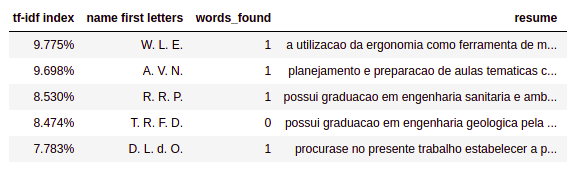

In [165]:
print("\nTESTE 1 - Sem word2vec - Termos usados : ['fisico', 'solo', 'nascente', 'nascentes', 'hidrico']")
display(Image(os.path.join(datapath,'projeto1-sem-word2vec.png'), width=700)) 


TESTE 2 - Com word2vec - Termos expandidos : ['fisico', 'vegetacao', 'solo', 'subbacia', 'solos', 'ciliares', 'salino', 'hidrologico', 'foz', 'nascente', 'nascentes', 'hidrico', 'aerobio']


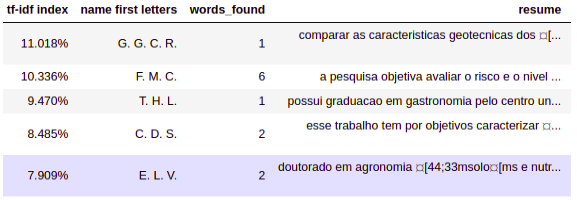

In [166]:
print("\nTESTE 2 - Com word2vec - Termos expandidos : ['fisico', 'vegetacao', 'solo', 'subbacia', 'solos', 'ciliares', 'salino', 'hidrologico', 'foz', 'nascente', 'nascentes', 'hidrico', 'aerobio']")
display(Image(os.path.join(datapath,'projeto1-com-word2vec.png'), width=700)) 

***

##### Teste expansão e busca com PROJETO 2

Título Projeto: __Desenvolvimento de tecnologia para tratamento de rejeito de minério de ferro com uso de separação por floculação e decantação magnética__








TESTE 1 - Sem word2vec - Termos usados : ['decantacao', 'rejeito', 'ferro', 'magnetica', 'minerio', 'floculacao']


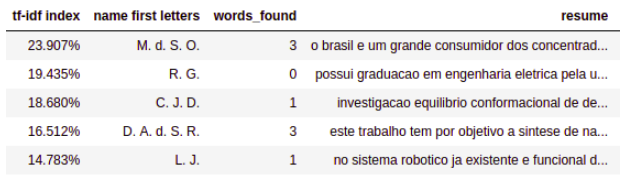

In [168]:
print("\nTESTE 1 - Sem word2vec - Termos usados : ['decantacao', 'rejeito', 'ferro', 'magnetica', 'minerio', 'floculacao']")
display(Image(os.path.join(datapath,'projeto2-sem-word2vec.png'), width=700)) 


TESTE 2 - Com word2vec - Termos expandidos : ['tomografia', 'zinco', 'decantacao', 'ressonancia', 'filtracao', 'rejeito', 'lama', 'nanofiltracao', 'residuo', 'ferro', 'minerios', 'magnetica', 'flotacao', 'minerio', 'floculacao']


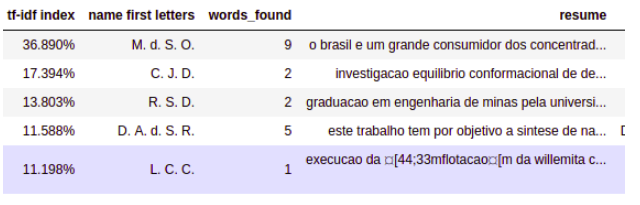

In [169]:
print("\nTESTE 2 - Com word2vec - Termos expandidos : ['tomografia', 'zinco', 'decantacao', 'ressonancia', 'filtracao', 'rejeito', 'lama', 'nanofiltracao', 'residuo', 'ferro', 'minerios', 'magnetica', 'flotacao', 'minerio', 'floculacao']")
display(Image(os.path.join(datapath,'projeto2-com-word2vec.png'), width=700)) 

***

##### Teste expansão e busca com PROJETO 3

Título Projeto: __Suplementação de minerais orgânicos em dietas para frangos caipira__








TESTE 1 - Sem word2vec - Termos usados : ['organicos', 'suplementacao', 'frangos', 'dieta', 'mineral', 'minerais', 'dietas', 'frango', 'organico', 'caipira']


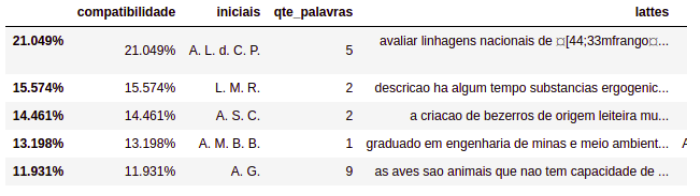

In [170]:
print("\nTESTE 1 - Sem word2vec - Termos usados : ['organicos', 'suplementacao', 'frangos', 'dieta', 'mineral', 'minerais', 'dietas', 'frango', 'organico', 'caipira']")
display(Image(os.path.join(datapath,'projeto3-sem-word2vec.png'), width=700)) 


TESTE 2 - Com word2vec - Termos expandidos : ['suina', 'caprino', 'organico', 'racao', 'inorganicos', 'suplementacao', 'frangos', 'caipiras', 'minerais', 'nitrogenados', 'fertilizante', 'racoes', 'caipira', 'argila', 'organicos', 'dieta', 'mineral', 'codorna', 'dietas', 'frango', 'codornas']


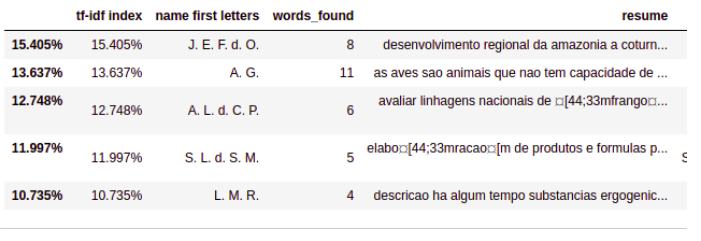

In [172]:
print("\nTESTE 2 - Com word2vec - Termos expandidos : ['suina', 'caprino', 'organico', 'racao', 'inorganicos', 'suplementacao', 'frangos', 'caipiras', 'minerais', 'nitrogenados', 'fertilizante', 'racoes', 'caipira', 'argila', 'organicos', 'dieta', 'mineral', 'codorna', 'dietas', 'frango', 'codornas']")
display(Image(os.path.join(datapath,'projeto3-com-word2vec.png'), width=700)) 

***

##### Teste expansão e busca com PROJETO 4

Título Projeto: __Avaliação da atividade biocida de extratos burtos de plantas medicinais nativas do alto paraopeba frente a bioterioração da pedra sabão__








TESTE 1 - Sem word2vec - Termos usados : ['alto', 'biocida', 'medicinais', 'sabao', 'medicinal', 'nativas', 'paraopeba', 'nativa', 'pedra', 'bioterioracao']


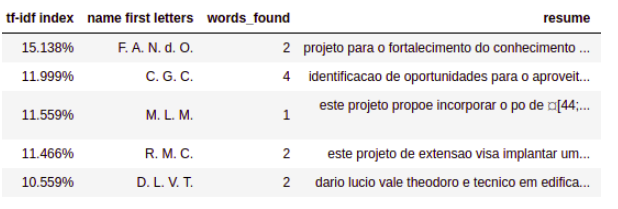

In [173]:
print("\nTESTE 1 - Sem word2vec - Termos usados : ['alto', 'biocida', 'medicinais', 'sabao', 'medicinal', 'nativas', 'paraopeba', 'nativa', 'pedra', 'bioterioracao']")
display(Image(os.path.join(datapath,'projeto4-sem-word2vec.png'), width=700)) 


TESTE 2 - Com word2vec - Termos expandidos : ['ornamental', 'saboes', 'arboreas', 'lama', 'pedra', 'aromaticas', 'arborea', 'medicinais', 'organofosforado', 'briquetes', 'paraopeba', 'medicinal', 'frutiferas', 'copolimero', 'sabao', 'nativas', 'fitoterapicos', 'nativa', 'bioterioracao', 'alto', 'biocida', 'atlantica']


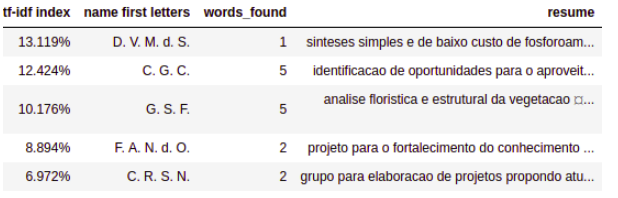

In [174]:
print("\nTESTE 2 - Com word2vec - Termos expandidos : ['ornamental', 'saboes', 'arboreas', 'lama', 'pedra', 'aromaticas', 'arborea', 'medicinais', 'organofosforado', 'briquetes', 'paraopeba', 'medicinal', 'frutiferas', 'copolimero', 'sabao', 'nativas', 'fitoterapicos', 'nativa', 'bioterioracao', 'alto', 'biocida', 'atlantica']")
display(Image(os.path.join(datapath,'projeto4-com-word2vec.png'), width=700)) 

### Consideração final

O resutaldo com o word2vec foi considerado interessante, porque por exemplo, no projeto 3 trouxe o servidor J.E.F.D.O em primeiro lugar, sendo que esse servidor tem um trabalho muito importante no tema pesquisado, com especialidade na área de codornas (palavra que não havia sido considerada na busca sem o word2vec). Outro fator relevante é que a posição do servidor A.G. subiu para segundo, sendo que ele é um dos mais importantes profissionais nessa área. O servidor A.L.D.C.P. teve sua posição alterada de primeiro para terceiro em decorrência da maior relevância dos demais considerando um conjunto maior de termos pesquisados. 


### Teste com remoção de verbos do corpus

Considerando que os verbos adicionam pouco significado ao currículo, foi realizao um outro teste considerando o mesmo corpus de 400mil currículos, porém removendo os verbos. Diante da inexistência dessa lista no pacote nltk, para remoção dos verbos, foi necessária a criação de uma lista com os verbos e suas possíveis conjugações. 

Para criação dessa lista foi usado um crawler nos sites https://www.conjugacao.com.br/verbos-populares e http://www.conjuga-me.net, sendo que o primeiro link contém uma lista com 5000 verbos em português na sua forma infinitiva, e o segundo é uma site que mostra todas as conjugações possíveis do verbo considerando sua forma infinitiva. Foi gerada uma lista com 260524 verbos, considerando sua forma infinitiva e todas suas conjugações possíveis. 

A lista de verbos em português criada pode ser útil para outros projetos de representação da informação. A mesma será disponibilizada juntamente com esse projeto no repositório git. No entanto, durante os testes foi identificado uma situação importante com relação a remoção de verbos do corpus. Cada projeto deve avaliar a sua necessidade e viabilidade, haja vista que algumas conjugações de verbos são também substântivos. Ex: O verbo __rejeitar__, tem na sua conjugação perante o pronome eu, a forma __rejeito__, no entanto, rejeito também é um *substântivo*. No nosso teste, alguns currículos que continham a expressão “rejeito de minério” tiveram a palavra rejeito removida. Isso pode alterar o resultado da representação e consequentemente da recuperação da informação. 



A imagem abaixo exibe um resultado da expansão com o corpus considerando verbos e não considerando verbos.


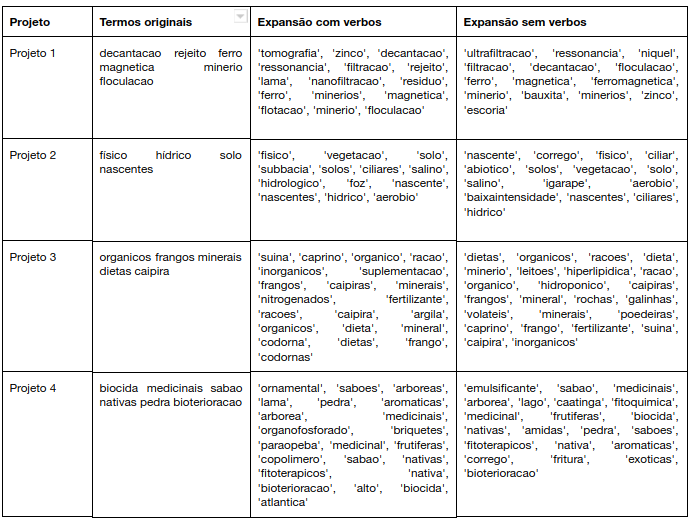

In [175]:
print("\nA imagem abaixo exibe um resultado da expansão com o corpus considerando verbos e não considerando verbos.")
display(Image(os.path.join(datapath,'comparativo-com-sem-verbos.png'), width=700)) 